In [232]:
import string
import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from patsy import dmatrices

from sklearn.metrics import roc_curve, auc, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize

from scipy import interp
from scipy.stats import chi2_contingency, chi2

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

# Import data

In [179]:
# Create Taylor Swift Dataframe
taylor_df = pd.read_csv('./taylor_swift_IP.csv')
taylor_df.columns = ['unnamed', 'sonnet_index', 'syllables', 's1', 's2', 's3',
       's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12',
       'word_list', 'sonnet_num', 'author', 'polarity', 'subjectivity']

taylor_df['sonnet'] = taylor_df.apply(lambda x: 0, axis=1)

# unnecessary columns

taylor_df = taylor_df.drop('unnamed', axis=1)

taylor_df.head()

,sonnet_index,syllables,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,word_list,sonnet_num,author,polarity,subjectivity,sonnet
0,1,11,stress,stress,stress,stress,stress,unstress,stress,stress,stress,stress,unstress,missing,"['And', 'I', 'was', 'right', 'there', 'beside'...",1,taylor_swift,0.285714,0.535714,0
1,22,11,stress,stress,stress,stress,stress,stress,stress,stress,unstress,stress,unstress,missing,"['So', 'go', 'and', 'tell', 'your', 'friends',...",22,taylor_swift,0.000000,0.000000,0
2,26,11,stress,stress,stress,stress,unstress,stress,stress,unstress,stress,unstress,stress,missing,"['And', 'if', 'you', 'come', 'around', 'saying...",26,taylor_swift,-0.500000,1.000000,0
3,35,11,stress,stress,stress,stress,stress,stress,stress,stress,unstress,unstress,stress,missing,"['He', 'says', 'he', 'so', 'in', 'love', 'he',...",35,taylor_swift,0.250000,0.800000,0
4,46,11,stress,stress,stress,stress,unstress,stress,stress,stress,stress,stress,stress,missing,"['So', 'I', 'drive', 'home', 'alone', 'as', 'I...",46,taylor_swift,0.000000,0.000000,0


In [180]:
taylor_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 470 entries, 0 to 469
Data columns (total 20 columns):
sonnet_index    470 non-null int64
syllables       470 non-null int64
s1              470 non-null object
s2              470 non-null object
s3              470 non-null object
s4              470 non-null object
s5              470 non-null object
s6              470 non-null object
s7              470 non-null object
s8              470 non-null object
s9              470 non-null object
s10             470 non-null object
s11             470 non-null object
s12             470 non-null object
word_list       470 non-null object
sonnet_num      470 non-null int64
author          470 non-null object
polarity        470 non-null float64
subjectivity    470 non-null float64
sonnet          470 non-null int64
dtypes: float64(2), int64(4), object(14)
memory usage: 73.5+ KB


In [181]:
# Create BSB Dataframe
bsb_df = pd.read_csv('./bsb_IP.csv')
bsb_df.columns = ['unnamed', 'sonnet_index', 'syllables', 's1', 's2', 's3',
       's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12',
       'word_list', 'sonnet_num', 'author', 'polarity', 'subjectivity']

bsb_df['sonnet'] = bsb_df.apply(lambda x: 0, axis=1)

# unnecessary columns

bsb_df = bsb_df.drop('unnamed', axis=1)

bsb_df.head()

,sonnet_index,syllables,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,word_list,sonnet_num,author,polarity,subjectivity,sonnet
0,0,11,stress,stress,stress,unstress,stress,unstress,unstress,stress,stress,stress,stress,missing,"['Your', 'ten', 'thousand', 'promises', 'That'...",0,bsb,0.0,0.0,0
1,8,11,stress,stress,unstress,stress,stress,stress,stress,unstress,stress,stress,stress,missing,"['Who', 'wasted', 'my', 'time', 'and', 'money'...",8,bsb,-0.2,0.0,0
2,24,11,stress,stress,stress,unstress,stress,unstress,unstress,stress,stress,stress,stress,missing,"['Your', 'ten', 'thousand', 'promises', 'That'...",24,bsb,0.0,0.0,0
3,27,11,stress,stress,stress,unstress,stress,unstress,unstress,stress,stress,stress,stress,missing,"['Your', 'ten', 'thousand', 'promises', 'That'...",27,bsb,0.0,0.0,0
4,28,11,stress,stress,stress,missing,stress,missing,stress,stress,stress,missing,stress,missing,"['What', 'a', 'lie', '(what', 'a', 'lie)', 'Yo...",28,bsb,0.0,0.0,0


In [182]:
bsb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1235 entries, 0 to 1234
Data columns (total 20 columns):
sonnet_index    1235 non-null int64
syllables       1235 non-null int64
s1              1235 non-null object
s2              1235 non-null object
s3              1235 non-null object
s4              1235 non-null object
s5              1235 non-null object
s6              1235 non-null object
s7              1235 non-null object
s8              1235 non-null object
s9              1235 non-null object
s10             1235 non-null object
s11             1235 non-null object
s12             1235 non-null object
word_list       1235 non-null object
sonnet_num      1235 non-null int64
author          1235 non-null object
polarity        1235 non-null float64
subjectivity    1235 non-null float64
sonnet          1235 non-null int64
dtypes: float64(2), int64(4), object(14)
memory usage: 193.0+ KB


In [183]:
# Create full_sonnet Dataframe
poems_df = pd.read_csv('./full_sonnet_df.csv')
poems_df.head()
poems_df.columns = ['unnamed0','unnamed1', 'sonnet_index', 'syllables', 's1', 's2', 's3',
       's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12',
       'word_list', 'sonnet_num', 'author', 'polarity', 'subjectivity','sonnet']

# drop unnecessary columns

poems_df = poems_df.drop('unnamed0', axis=1)
poems_df = poems_df.drop('unnamed1', axis=1)

poems_df.head()

,sonnet_index,syllables,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,word_list,sonnet_num,author,polarity,subjectivity,sonnet
0,2,10,unstress,stress,unstress,stress,unstress,stress,unstress,stress,unstress,stress,missing,missing,"['From', 'fairest', 'creatures', 'we', 'desire...",1,Shakespeare,0.00,0.00,1
1,3,11,unstress,stress,stress,stress,unstress,stress,stress,stress,unstress,stress,missing,missing,"['That', 'thereby', 'beauty', 'rose', 'might',...",1,Shakespeare,0.60,0.95,1
2,4,10,stress,stress,unstress,missing,missing,stress,stress,stress,unstress,stress,missing,missing,"['But', 'as', 'the', 'riper', 'should', 'by', ...",1,Shakespeare,0.00,0.00,1
3,5,10,unstress,stress,unstress,stress,stress,stress,unstress,stress,unstress,unstress,missing,missing,"['His', 'tender', 'heir', 'might', 'bear', 'hi...",1,Shakespeare,0.00,0.00,1
4,6,10,stress,stress,stress,unstress,unstress,stress,stress,stress,stress,stress,missing,missing,"['But', 'thou', 'contracted', 'to', 'thine', '...",1,Shakespeare,0.65,0.90,1


In [184]:
# Randomly take subset of the full sonnets data
poems_df = poems_df.drop(poems_df.sample(frac=.65).index)

In [185]:
poems_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1792 entries, 0 to 5118
Data columns (total 20 columns):
sonnet_index    1792 non-null int64
syllables       1792 non-null int64
s1              1792 non-null object
s2              1792 non-null object
s3              1792 non-null object
s4              1792 non-null object
s5              1792 non-null object
s6              1792 non-null object
s7              1792 non-null object
s8              1792 non-null object
s9              1792 non-null object
s10             1792 non-null object
s11             1792 non-null object
s12             1792 non-null object
word_list       1792 non-null object
sonnet_num      1792 non-null int64
author          1762 non-null object
polarity        1792 non-null float64
subjectivity    1792 non-null float64
sonnet          1792 non-null int64
dtypes: float64(2), int64(4), object(14)
memory usage: 294.0+ KB


In [186]:
# Stacking the Taylor Swift, BSB, and Poems dataframes

final_df = pd.concat([taylor_df, bsb_df, poems_df])
final_df.head()
final_df.to_csv('final_df.csv')

In [187]:
final_df.shape

(3497, 20)

# Check correlation

In [188]:
final_df.drop("sonnet_index",axis=1).corr()

,syllables,sonnet_num,polarity,subjectivity,sonnet
syllables,1.000000,0.448321,-0.049101,-0.064106,-0.621846
sonnet_num,0.448321,1.000000,-0.066798,-0.073531,-0.727169
polarity,-0.049101,-0.066798,1.000000,0.202040,0.065399
subjectivity,-0.064106,-0.073531,0.202040,1.000000,0.113212
sonnet,-0.621846,-0.727169,0.065399,0.113212,1.000000


# Baseline

In [189]:
print(np.mean(final_df.sonnet))

0.5124392336288247


# Logistic Regression

In [190]:
logreg = LogisticRegression()

formula = 'sonnet ~ syllables + C(s1) + C(s2) + C(s3) + C(s4) + C(s5) + C(s6) + C(s7) + C(s8) + C(s9) + C(s10) + C(s11) + C(s12) + polarity + subjectivity -1'
Y, X = dmatrices(formula, data=final_df)

In [191]:
#Prediction values
# ypred = logreg.predict(X)
# mistakes_df['algorithm'] = ypred

In [192]:
interaction_formula = ''' sonnet ~ syllables + (C(s1) + C(s2) + C(s3) + C(s4) + C(s5) + C(s6) + C(s7) + C(s8) + 
C(s9) + C(s10) + C(s11) + C(s12))**2 + polarity + subjectivity -1'''
Yint, Xint = dmatrices(interaction_formula, data=final_df, return_type='dataframe')
Xint = (Xint - Xint.mean()) / Xint.std()
Xint.dropna(axis=1, inplace=True)

In [193]:
Yint.shape, Xint.shape

((3497, 1), (3497, 286))

In [194]:
Y.shape, X.shape

((3497, 1), (3497, 28))

In [195]:
np.mean(Y)

array(0.51243923)

# Inspect Model 1

## Summary

In [196]:
import statsmodels.api as sm

logit_model1=sm.Logit(Y,X)
result1=logit_model1.fit()
print(result1.summary())

         Current function value: 0.105862
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                 sonnet   No. Observations:                 3497
Model:                          Logit   Df Residuals:                     3469
Method:                           MLE   Df Model:                           27
Date:                Sat, 12 Oct 2019   Pseudo R-squ.:                  0.8472
Time:                        11:36:52   Log-Likelihood:                -370.20
converged:                      False   LL-Null:                       -2422.9
                                        LLR p-value:                     0.000
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
C(s1)[missing]        27.7628      3.087      8.993      0.000      21.712      33.814
C(s1)[stress]         27.6406      3.075 

/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [197]:
print(result1.summary2())

                               Results: Logit
Model:                   Logit                Pseudo R-squared:     0.847   
Dependent Variable:      sonnet               AIC:                  796.3982
Date:                    2019-10-12 11:36     BIC:                  968.8687
No. Observations:        3497                 Log-Likelihood:       -370.20 
Df Model:                27                   LL-Null:              -2422.9 
Df Residuals:            3469                 LLR p-value:          0.0000  
Converged:               0.0000               Scale:                1.0000  
No. Iterations:          35.0000                                            
----------------------------------------------------------------------------
                    Coef.   Std.Err.     z     P>|z|     [0.025     0.975]  
----------------------------------------------------------------------------
C(s1)[missing]     27.7628     3.0871   8.9930 0.0000     21.7121    33.8135
C(s1)[stress]      27.6406    

In [198]:
import statsmodels.formula.api as smf

model1 = smf.glm(formula = formula, data=final_df, family=sm.families.Binomial())
my_model1 = model1.fit()
print(my_model1.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 sonnet   No. Observations:                 3497
Model:                            GLM   Df Residuals:                     3469
Model Family:                Binomial   Df Model:                           27
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -370.20
Date:                Sat, 12 Oct 2019   Deviance:                       740.40
Time:                        11:36:52   Pearson chi2:                 5.07e+03
No. Iterations:                    22   Covariance Type:             nonrobust
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
C(s1)[missing]        27.7628      3.087      8.993      0.000      21.712      33.814
C(s1)[stress]         27.640

## step-wise selection

In [199]:
def step_wise_forward_selected(data, predictors, response, AIC=True):
    """Logistic model designed by forward selection.
    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response
    response: string, name of response column in data
    Returns:
    --------
    model: an "optimal" fitted statsmodels linear model
           with an intercept
           selected by forward selection
           evaluated by AIC

    inspiration provided by https://planspace.org/20150423-forward_selection_with_statsmodels/
    """
    print("remaining = ", predictors)
    print("response = ", response)
    selected = []
    current_score, best_new_score = 99999, 99999  # set starting scores high so we get lower score
    
    while predictors and current_score == best_new_score:
#         print("new round")
#         print("current_score = ", current_score)
        scores_with_candidates = []
#         print("scores with candidates = ", scores_with_candidates)
        for candidate in predictors:
#             print("candidate = ", candidate)
            formula = "{} ~ {} + 1".format(response,' + '.join(selected + [candidate]))
#             print("candidate formula = ", formula)
            if AIC:
                score = smf.glm(formula=formula, data=data, family=sm.families.Binomial()).fit().aic
            else:
                score = smf.glm(formula=formula, data=data, family=sm.families.Binomial()).fit().bic
#             print("score = ", score)
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort(reverse=True)
#         print("scores with candidates = ", scores_with_candidates)
        best_new_score, best_candidate = scores_with_candidates.pop()
#         print("best new score = ", best_new_score)
#         print("best candidate = ", best_candidate)
        if current_score > best_new_score:
            predictors.remove(best_candidate)
            selected.append(best_candidate)
#             print("selected = ", selected)
            current_score = best_new_score
    
    formula = "{} ~ {} + 1".format(response,' + '.join(selected))
    return formula

### AIC

In [200]:
my_pred = ["syllables","C(s1)","C(s2)","C(s3)","C(s4)","C(s5)","C(s6)","C(s7)","C(s8)","C(s9)","C(s10)","C(s11)","C(s12)","polarity","subjectivity"]
aic_step_formula = step_wise_forward_selected(final_df, my_pred, "sonnet", True)
print(aic_step_formula)

remaining =  ['syllables', 'C(s1)', 'C(s2)', 'C(s3)', 'C(s4)', 'C(s5)', 'C(s6)', 'C(s7)', 'C(s8)', 'C(s9)', 'C(s10)', 'C(s11)', 'C(s12)', 'polarity', 'subjectivity']
response =  sonnet
sonnet ~ C(s11) + C(s1) + C(s7) + C(s3) + C(s5) + C(s9) + C(s12) + syllables + C(s10) + C(s2) + C(s4) + subjectivity + C(s6) + C(s8) + 1


In [201]:
Ya, Xa = dmatrices(aic_step_formula, data=final_df)

In [202]:
modela = smf.glm(formula = aic_step_formula, data=final_df, family=sm.families.Binomial())
my_modela = modela.fit()
print(my_modela.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 sonnet   No. Observations:                 3497
Model:                            GLM   Df Residuals:                     3470
Model Family:                Binomial   Df Model:                           26
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -371.02
Date:                Sat, 12 Oct 2019   Deviance:                       742.04
Time:                        11:37:04   Pearson chi2:                 4.91e+03
No. Iterations:                    22   Covariance Type:             nonrobust
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             27.9275      3.113      8.972      0.000      21.826      34.028
C(s11)[T.stress]      -5.195

### BIC

In [203]:
my_pred = ["syllables","C(s1)","C(s2)","C(s3)","C(s4)","C(s5)","C(s6)","C(s7)","C(s8)","C(s9)","C(s10)","C(s11)","C(s12)","polarity","subjectivity"]
bic_step_formula = step_wise_forward_selected(final_df, my_pred, "sonnet", False)
print(bic_step_formula)

remaining =  ['syllables', 'C(s1)', 'C(s2)', 'C(s3)', 'C(s4)', 'C(s5)', 'C(s6)', 'C(s7)', 'C(s8)', 'C(s9)', 'C(s10)', 'C(s11)', 'C(s12)', 'polarity', 'subjectivity']
response =  sonnet
sonnet ~ C(s11) + C(s1) + C(s7) + C(s3) + C(s5) + C(s9) + syllables + C(s12) + C(s10) + C(s2) + subjectivity + C(s4) + 1


In [204]:
Yb, Xb = dmatrices(bic_step_formula, data=final_df)

In [205]:
modelb = smf.glm(formula = bic_step_formula, data=final_df, family=sm.families.Binomial())
my_modelb = modelb.fit()
print(my_modelb.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 sonnet   No. Observations:                 3497
Model:                            GLM   Df Residuals:                     3474
Model Family:                Binomial   Df Model:                           22
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -376.85
Date:                Sat, 12 Oct 2019   Deviance:                       753.70
Time:                        11:37:15   Pearson chi2:                 5.28e+03
No. Iterations:                    22   Covariance Type:             nonrobust
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             26.5920      3.029      8.780      0.000      20.656      32.528
C(s11)[T.stress]      -5.183

## Cross Val Scores

In [206]:
scores1 = cross_val_score(logreg, X, np.ravel(Y), cv=5)
print(scores1)
print(np.mean(scores1))

[0.97428571 0.95571429 0.95565093 0.94706724 0.95135908]
0.9568154506437768


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

In [207]:
scoresa = cross_val_score(logreg, Xa, np.ravel(Ya), cv=5)
print(scoresa)
print(np.mean(scoresa))

[0.97571429 0.96       0.95565093 0.94420601 0.95708155]
0.9585305538524423


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

In [208]:
scoresb = cross_val_score(logreg, Xb, np.ravel(Yb), cv=5)
print(scoresb)
print(np.mean(scoresb))

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[0.97571429 0.95857143 0.95565093 0.94420601 0.94849785]
0.9565281013693031


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [209]:
logreg.fit(X,np.ravel(Y))
pp = logreg.predict_proba(X)
y_pred_50pct = logreg.predict(X)

model_features = ['syllables', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 'polarity', 'subjectivity']

# zip(model_features, logreg.coef_)

len(model_features), len(logreg.coef_[0])
len(X.design_info.column_names), len(logreg.coef_[0])

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


(28, 28)

# ROC curve

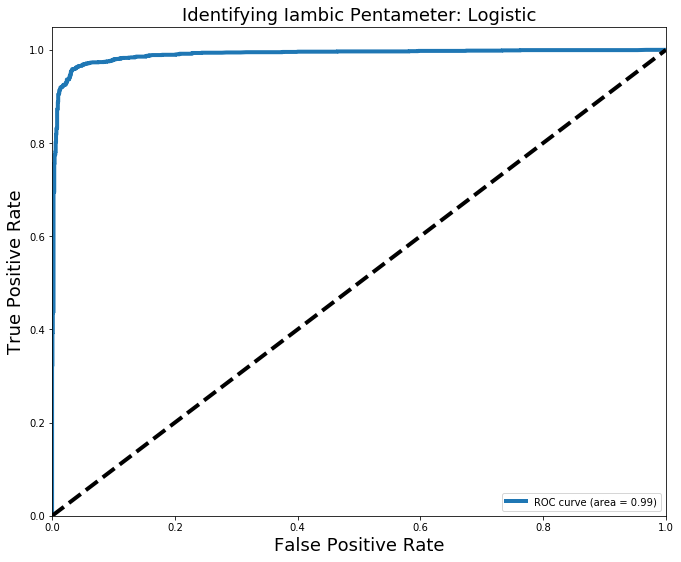

In [210]:
Ytrue = pd.Series(np.ravel(Y))
Y_score = logreg.decision_function(X)

FPR = dict()
TPR = dict()
ROC_AUC = dict()

# For class 1, find the area under the curve
FPR[1], TPR[1], _ = roc_curve(Ytrue, Y_score)
ROC_AUC[1] = auc(FPR[1], TPR[1])

# Plot of a ROC curve for class 1 (has_cancer)
plt.figure(figsize=[11,9])
plt.plot(FPR[1], TPR[1], label='ROC curve (area = %0.2f)' % ROC_AUC[1], linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Identifying Iambic Pentameter: Logistic', fontsize=18)
plt.legend(loc="lower right")
plt.show()

# Confusion Matrix

In [211]:
Ytrue = pd.Series(np.ravel(Y))
Ypred50 = pd.Series(y_pred_50pct)
pd.crosstab(Ytrue, Ypred50, rownames = ['True'], colnames = ['Predicted'], margins = True)

Predicted,0.0,1.0,All
True,,,
0.0,1649,56,1705
1.0,79,1713,1792
All,1728,1769,3497


# Model Evaluation:

### Deviance Chi-Squared Test

In [235]:
# Comparing Reduced vs. Full Model

g_full_model = my_model1.deviance     # values from summary tables above
g_reduced_model = my_modelb.deviance

delta_G_squared = g_reduced_model - g_full_model
print(delta_G_squared)

chi_val = chi2.isf(0.05, 22, loc=0, scale=1) # where df is from reduced model
print(chi_val)

13.301122101709439
33.92443847144379


Thus, since our delta G-squared value is smaller than our chi-squared value, we fail to reject the null hypothesis in favor of the alternative which is our reduced model.

### Wald's Test

In [ ]:
# Testing for the significance of individual regression coefficients
# Assume Ho: Bi=0 vs Ha: Bi!=0